In [1]:
import torchvision.transforms as transforms
import os
import json
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw, Image, ImageFont
from IPython.display import clear_output, HTML, display
import imageio as imio
from einops import rearrange

import sys
sys.path.append('..')
from datasets.dataset_utils import listdir_nohidden, random_rotation_augment

In [2]:
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])
  
def Ry(theta):
    return np.matrix([[ np.cos(theta), 0, np.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-np.sin(theta), 0, np.cos(theta)]])
  
def Rz(theta):
    return np.matrix([[ np.cos(theta), -np.sin(theta), 0 ],
                   [ np.sin(theta), np.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

In [3]:
def normalize_trajectory(Rt, center='first', normalize_rotation=True):
    assert center in ['first', 'mid'], 'center must be either "first" or "mid", got {}'.format(center)

    seq_len = Rt.shape[1]

    if center == 'first':
        origin_frame = 0
    elif center == 'mid':
        origin_frame = seq_len // 2
    else:
        # return unmodified Rt
        return Rt

    if normalize_rotation:
        origins = Rt[:, origin_frame : origin_frame + 1].expand_as(Rt).reshape(-1, 4, 4).inverse()
        normalized_Rt = torch.bmm(Rt.view(-1, 4, 4), origins)
        normalized_Rt = normalized_Rt.view(-1, seq_len, 4, 4)
    else:
        camera_pose = Rt.inverse()
        origins = camera_pose[:, origin_frame : origin_frame + 1, :3, 3]
        camera_pose[:, :, :3, 3] = camera_pose[:, :, :3, 3] - origins
        normalized_Rt = camera_pose.inverse()

    return normalized_Rt

In [33]:
resize_transform_rgb = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
resize_transform_depth = transforms.Compose([transforms.Resize(64)])

episode_path = '../data/replica_all/train/51'
episode_path = '../data/clevr/train/04'
with open(os.path.join(episode_path, 'cameras.json'), 'r') as f:
    cameras = json.load(f)

Rt = []
K = []
rgb = []
depth = []
for idx, i in enumerate(list(range(10))):
    Rt.append(torch.Tensor(cameras[i]['Rt']))
    K.append(torch.Tensor(cameras[i]['K']))

    _rgb = os.path.join(episode_path, str(i).zfill(3) + '_rgb.png')
    _rgb = resize_transform_rgb(Image.open(_rgb))
    rgb.append(_rgb[:3, :, :])

    _depth = os.path.join(episode_path, str(i).zfill(3) + '_depth.tiff')
    # We dont want to normalize depth values
    _depth = resize_transform_depth(Image.open(_depth))
    depth.append(torch.from_numpy(np.array(_depth)).unsqueeze(0))
    
rgb = torch.stack(rgb)
depth = torch.stack(depth).float()
K = torch.stack(K)
Rt = torch.stack(Rt)

Rt[:, :3, :3] = Rt[:, :3, :3] @ Rx(np.pi/2)
Rt[:, 3, 3] *= -1

# print(Rt[:4])
# Rt[:, [1, 2], 3] = Rt[:, [2,1], 3]
# print(Rt[:4])
# Rt[:, :, 3] *= -1

# Rt = Rt.inverse()
# print(Rt[:4])

# Rt = Rt.unsqueeze(0)  # add batch dimension
# Rt = normalize_trajectory(Rt, center='first', normalize_rotation=True)
# Rt = Rt[0]  # remove batch dimension

Rt = Rt.inverse()
print(Rt)

tensor([[[ 6.5587e-01,  3.7182e-01, -6.5695e-01, -7.5859e+00],
         [ 5.7563e-08, -8.7028e-01, -4.9256e-01, -5.6876e+00],
         [-7.5488e-01,  3.2305e-01, -5.7079e-01, -6.5909e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 6.5587e-01,  3.7182e-01, -6.5695e-01, -7.5859e+00],
         [ 5.7563e-08, -8.7028e-01, -4.9256e-01, -5.6876e+00],
         [-7.5488e-01,  3.2305e-01, -5.7079e-01, -6.5909e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 1.9056e-01,  4.8353e-01, -8.5433e-01, -9.8651e+00],
         [-1.1668e-09, -8.7028e-01, -4.9256e-01, -5.6876e+00],
         [-9.8168e-01,  9.3861e-02, -1.6584e-01, -1.9150e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-3.2581e-01,  4.6568e-01, -8.2279e-01, -9.5009e+00],
         [ 2.3965e-07, -8.7028e-01, -4.9256e-01, -5.6876e+00],
         [-9.4543e-01, -1.6048e-01,  2.8355e-01,  3.2741e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [34]:
rgb_current = rearrange(rgb, 'b c h w -> b h w c')
animation_filename = 'rgb.gif'
imio.mimsave(animation_filename, rgb_current, fps=5)
display(HTML('<img src={}>'.format(animation_filename)))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

tensor([-7.5859, -7.5859, -9.8651, -9.5009, -6.5909, -1.9150,  3.2741,  7.5859,
         9.8651,  9.5009]) tensor([-5.6876, -5.6876, -5.6876, -5.6876, -5.6876, -5.6876, -5.6876, -5.6876,
        -5.6876, -5.6876]) tensor([-6.5909, -6.5909, -1.9150,  3.2741,  7.5859,  9.8651,  9.5009,  6.5909,
         1.9150, -3.2741])
[[ 0.]
 [ 0.]
 [-1.]]
tensor([[7.8835],
        [5.9107],
        [6.8494]], dtype=torch.float64)
torch.Size([10, 3, 1]) torch.Size([10]) torch.Size([10]) torch.Size([10])


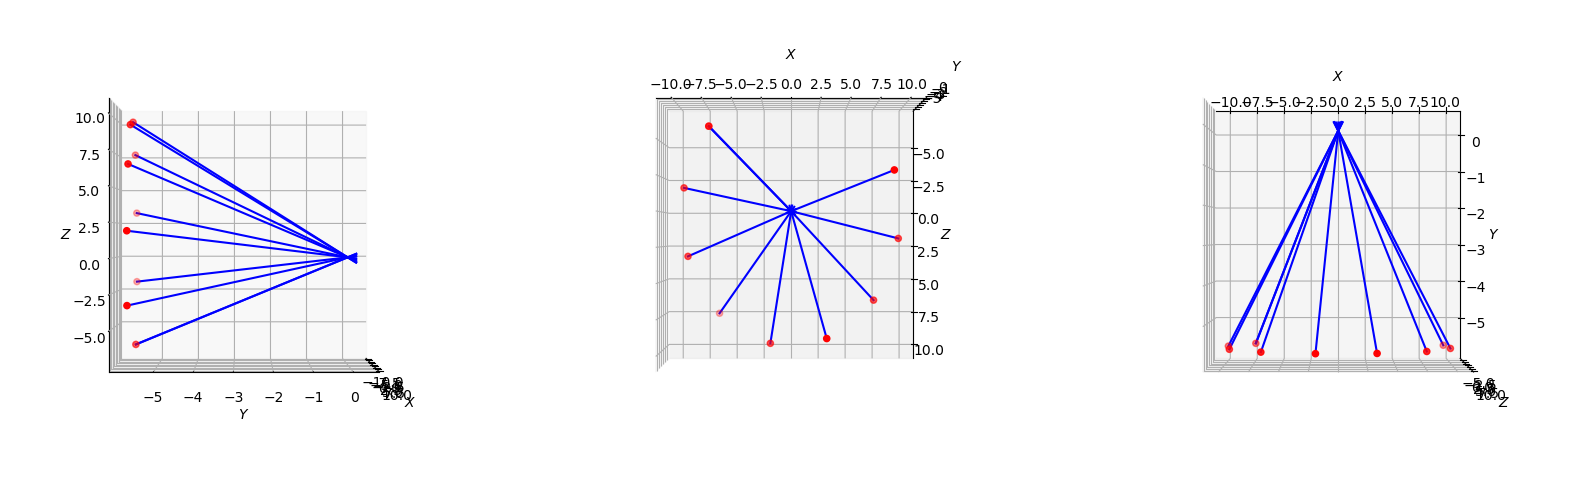

In [35]:
# Rt = Rt[:3]
X, Y, Z = Rt[:, 0, 3], Rt[:, 1, 3], Rt[:, 2, 3]
print(X, Y, Z)

unit_vecs = np.zeros((Rt.shape[0], 3, 1))
unit_vecs[:, 2] = -1
print(unit_vecs[0])
rot = Rt[:, :3, :3]

look_at = rot @ unit_vecs
look_at = look_at*12
print(look_at[0])

print(look_at.shape, X.shape, Y.shape, Z.shape)
# Plot X,Y,Z

fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter3D(X, Y, Z, c='red')
ax1.set_xlabel('$X$')
ax1.set_ylabel('$Y$')
ax1.set_zlabel('$Z$')
ax1.view_init(0, 0)

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter3D(X, Y, Z, c='red')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$Y$')
ax2.set_zlabel('$Z$')
ax2.view_init(-180, -90)

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter3D(X, Y, Z, c='red')
ax3.set_xlabel('$X$')
ax3.set_ylabel('$Y$')
ax3.set_zlabel('$Z$')
ax3.view_init(90, -90)

for idx in range(len(look_at)):
    ax1.plot3D([X[idx], X[idx] + look_at[idx][0]], 
               [Y[idx], Y[idx] + look_at[idx][1]],
               [Z[idx], Z[idx] + look_at[idx][2]], c='blue')
    ax2.plot3D([X[idx], X[idx] + look_at[idx][0]], 
               [Y[idx], Y[idx] + look_at[idx][1]],
               [Z[idx], Z[idx] + look_at[idx][2]], c='blue')
    ax3.plot3D([X[idx], X[idx] + look_at[idx][0]], 
               [Y[idx], Y[idx] + look_at[idx][1]],
               [Z[idx], Z[idx] + look_at[idx][2]], c='blue')
plt.show()
